In [1]:
import pandas as pd
import xarray as xr

- Specify metadata filename to read in
- Create dictionary of column to rename to, and a dictionary for variable units

In [6]:
p2fld = pl.Path('/nfs/grad/campaign/frc/2025/MetaData/')#FRC-VI_MetaData_20250922_preliminary.dat'
p2fld_out = pl.Path('/nfs/grad/campaign/frc/2025/MetaData.netcdf/')#FRC-VI_MetaData_20250922_preliminary.dat'

In [3]:
p2flist = list(p2fld.glob('*.dat'))
p2flist.sort()

In [4]:
column_rename_dict = {'Date year': 'year', 'Date month': 'month', \
                     'Date day': 'day', 'Date hour': 'hour', 'Date min': 'minute', \
                     'Ozone (DU):  Brewer ':'ozone', \
                     'Pressure (hPa):  PMOD- Setra Barometer':'pressure', \
                     'Pressure (hPa): PMOD- Setra Barometer - Uncertainty 1%': 'pressure',
                     'Ambient Temperature (oC):  MeteoSwiss':'air_temperature',\
                     'Relative  Humidity (%)':'relative_humidity', \
                     'Wind Speed (m/s)':'wind_speed',\
                     'Wind  Direction (deg)':'wind_direction',\
                     'Precipitable Water (mm):  MeteoSwiss':'precipitable_water_meteoswiss',\
                     'Estimated=0 ,  GPS-Measurement=1':'gps_flag', \
                     'Precipitable Water AERONET (mm)':'precipitable_water_aeronet'}

unit_dict = {'ozone':'DU', 'pressure':'hPa', 'air_temperature':'degC', 'relative_humidity':'percent', \
            'wind_speed':'m s-1', 'wind_direction':'deg', 'precipitable_water_meteoswiss':'mm', \
            'gps_flag':'Estimated=0 ,  GPS-Measurement=1','precipitable_water_aeronet':'mm'}

Read in text file

In [5]:
overwrite = True
for p2f in p2flist:
    save_filename = p2fld_out.joinpath(p2f.name.lower().split('.dat')[0]+'.nc')
    if save_filename.is_file():
        if overwrite:
            print(',', end = '')
        else:
            print('/', end = '')
    
    with open(p2f) as f:
        lines = f.readlines()               
    f.close()
    
    # Read in the lines with header info, appending the variable info and the column number for lines starting with '%'
    
    header_info_list = []
    column_info_list = []
    
    for header_ind in range(0, len(lines)):
        if lines[header_ind][0]=='%':
            pound_split = lines[header_ind][1:].split('#')
            if len(pound_split)>1:
                column_info_list.append(int(pound_split[0])-1)
                header_info_list.append(pound_split[1].split('\n')[0])            
            else:
                pass            
    
        else:
            continue
    
    # Initialize a dictionary with header info keys with empty lists
    
    metadata_dict = {}
    
    for header_info in header_info_list:
        metadata_dict[header_info] = []
    
    # - Read in all lines not commented out (starting with %)
    # - Split the line by a space (' '), remove all splits that are empty (if two or more spaces inbetween)
    # - Append all column information by column index, int if a date column, float for all else
    
    for line_ind in range(0, len(lines)):
        if lines[line_ind][0]=='%':
            continue
        else:
            pass
        
        line_list = list(filter(None, lines[line_ind].split(' ')))
    
        for column_ind in range(0, len(column_info_list)):
            if header_info_list[column_ind][0:4]=='Date':
                metadata_dict[header_info_list[column_ind]].append(int(line_list[column_info_list[column_ind]]))                
            else:
                metadata_dict[header_info_list[column_ind]].append(float(line_list[column_info_list[column_ind]]))    
    
    # - Convert dictionary into a dataframe
    # - Drop the first two indices (correspond to daily mean and standard deviation of the variables)
    # - Rename variables to more friendly variable `trings (i.e., remove spaces and extra info)
    
    df = pd.DataFrame(metadata_dict)
    df_modified = df.iloc[2:]
    df_renamed = df_modified.rename(columns=column_rename_dict)
    df_renamed = df_renamed.rename({col:'pressure' for col in df_modified.columns if 'pressure' in col.lower()}, axis = 1)
    df_renamed = df_renamed.rename({col:'air_temperature' for col in df_modified.columns if 'temperature' in col.lower()}, axis = 1)
    df_renamed = df_renamed.rename({col:'relative_humidity' for col in df_modified.columns if 'humidity' in col.lower()}, axis = 1)
    df_renamed = df_renamed.rename({col:'wind_speed' for col in df_modified.columns if 'wind speed' in col.lower()}, axis = 1)
    df_renamed = df_renamed.rename({col:'wind_direction' for col in df_modified.columns if 'direction' in col.lower()}, axis = 1)
    df_renamed = df_renamed.rename({col:'precipitable_water_meteoswiss' for col in df_modified.columns if 'meteoswiss' in col.lower()}, axis = 1)
    df_renamed = df_renamed.rename({col:'precipitable_water_aeronet' for col in df_modified.columns if 'aeronet' in col.lower()}, axis = 1)

    # Create timestamp from date columns, reset index to new timestamp
    
    timestamp = pd.to_datetime(df_renamed[['year', 'month', 'day', 'hour', 'minute']])
    df_renamed['time'] = timestamp
    df_reindexed = df_renamed.set_index('time')
    
    # Convert dataframe into dataset, add in unit information for variables and some global attributes
    
    ds = xr.Dataset.from_dataframe(df_reindexed)
    
    for unit_key in list(unit_dict.keys()):
        ds[unit_key].attrs['units'] = unit_dict[unit_key]
        
    ds.attrs['filename'] = p2f.name
    ds.attrs['description'] = 'PMOD FRC metadata converted from text to netcdf'
    ds.attrs['fill_value'] = -99.999
    
    # Save dataset to netcdf
    # break
    ds.to_netcdf(save_filename)
    print('.', end = '')

,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,..........

In [41]:
df_reindexed

,year,month,day,hour,minute,ozone,pressure,air_temperature,relative_humidity,wind_speed,wind_direction,precipitable_water_meteoswiss,gps_flag,precipitable_water_meteoswiss
time,,,,,,,,,,,,,,
2025-09-04 00:00:00,2025,9,4,0,0,-99.999,844.835,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999
2025-09-04 00:01:00,2025,9,4,0,1,-99.999,844.830,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999
2025-09-04 00:02:00,2025,9,4,0,2,-99.999,844.869,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999
2025-09-04 00:03:00,2025,9,4,0,3,-99.999,844.844,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999
2025-09-04 00:04:00,2025,9,4,0,4,-99.999,844.871,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-04 23:55:00,2025,9,4,23,55,-99.999,845.166,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999
2025-09-04 23:56:00,2025,9,4,23,56,-99.999,845.168,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999
2025-09-04 23:57:00,2025,9,4,23,57,-99.999,845.144,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999


In [42]:
df_modified

,Date year,Date month,Date day,Date hour,Date min,Ozone (DU): Brewer,Pressure (hPa): PMOD- Setra Barometer - Uncertainty 1%,Ambient Temperature (oC): PMOD/WRC - Uncertainty NA,Relative Humidity (%) - PMOD/WRC NA,Wind Speed (m/s) - Uncertainty NA,Wind Direction (deg) - Uncertainty NA,Precipitable Water (mm): MeteoSwiss - Uncertainty NA,"Estimated=0 , GPS-Measurement=1",Precipitable Water AERONET (mm) - Uncertainty NA
2,2025,9,4,0,0,-99.999,844.835,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999
3,2025,9,4,0,1,-99.999,844.830,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999
4,2025,9,4,0,2,-99.999,844.869,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999
5,2025,9,4,0,3,-99.999,844.844,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999
6,2025,9,4,0,4,-99.999,844.871,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437,2025,9,4,23,55,-99.999,845.166,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999
1438,2025,9,4,23,56,-99.999,845.168,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999
1439,2025,9,4,23,57,-99.999,845.144,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999
1440,2025,9,4,23,58,-99.999,845.129,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999


In [39]:
df_modified.rename({col:'precipitable_water_aeronet' for col in df_modified.columns if ('precipitable' in col.lower()) and ()}, axis = 1)

,year,month,day,hour,minute,ozone,pressure,air_temperature,relative_humidity,wind_speed,wind_direction,precipitable_water_meteoswiss,gps_flag,precipitable_water_meteoswiss,time
2,2025,9,4,0,0,-99.999,844.835,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999,2025-09-04 00:00:00
3,2025,9,4,0,1,-99.999,844.830,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999,2025-09-04 00:01:00
4,2025,9,4,0,2,-99.999,844.869,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999,2025-09-04 00:02:00
5,2025,9,4,0,3,-99.999,844.844,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999,2025-09-04 00:03:00
6,2025,9,4,0,4,-99.999,844.871,2.600,79.700,-99.999,-99.999,10.498,0.0,-99.999,2025-09-04 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437,2025,9,4,23,55,-99.999,845.166,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999,2025-09-04 23:55:00
1438,2025,9,4,23,56,-99.999,845.168,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999,2025-09-04 23:56:00
1439,2025,9,4,23,57,-99.999,845.144,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999,2025-09-04 23:57:00
1440,2025,9,4,23,58,-99.999,845.129,-99.999,-99.999,-99.999,-99.999,-99.999,0.0,-99.999,2025-09-04 23:58:00


# plot some

In [8]:
p2fld = pl.Path('/nfs/grad/campaign/frc/2025/MetaData.netcdf/')
ds = xr.open_mfdataset(p2fld.glob('*'))

(0.0, 40.6107)

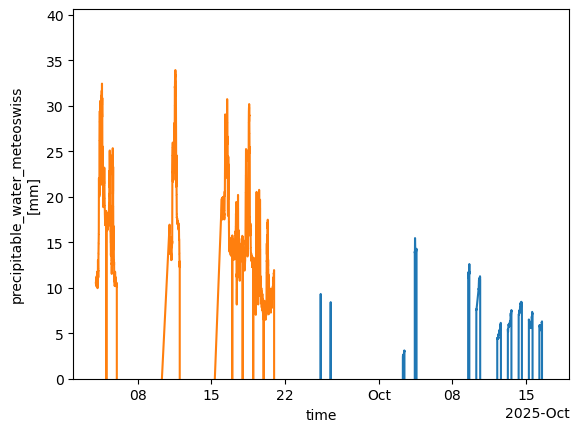

In [12]:
f,a = plt.subplots()
ds.precipitable_water_aeronet.plot(ax = a)
ds.precipitable_water_meteoswiss.plot(ax = a)
a.set_ylim(bottom = 0)

In [13]:
ds

<xarray.Dataset> Size: 5MB
Dimensions:                        (time: 41760)
Coordinates:
  * time                           (time) datetime64[ns] 334kB 2025-09-04 ......
Data variables: (12/14)
    year                           (time) int64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    month                          (time) int64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    day                            (time) int64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    hour                           (time) int64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    minute                         (time) int64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    ozone                          (time) float64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    ...                             ...
    relative_humidity              (time) float64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    wind_speed                     (time) float64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    wind_direction                 (time) float64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    precipitable_water_meteoswiss  (time) float64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    gps_flag                       (time) float64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
    precipitable_water_aeronet     (time) float64 334kB dask.array<chunksize=(1440,), meta=np.ndarray>
Attributes:
    filename:     FRC-VI_MetaData_20250904_preliminary.dat
    description:  PMOD FRC metadata converted from text to netcdf
    fill_value:   -99.999